In [1]:

import os
import fnmatch
import numpy as np
import torch
from tqdm import tqdm
import random
import json
from torch.utils.data import DataLoader
import glob
import os
import json
import matplotlib.pyplot as plt
import re

from dual_network import Dual3DCNN6 as Dual
# from Dataset_json import PXAI_Dataset
from decayLR import DecayLR
import torch
from torch.utils.data import Dataset
import SimpleITK as sitk
import numpy as np
import glob
from utilities import create_list_from_master_json, read_json_file, split_data
import os
import glob
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader

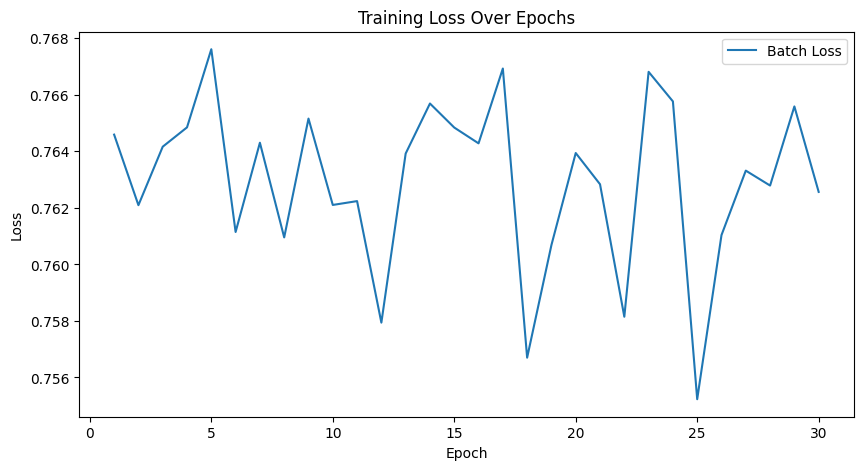

In [2]:

# Path to the loss file
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/loss_dose_json_simpleModel.txt'

# Read and process the data
epochs = []
batch_losses = []

with open(loss_file_path, 'r') as file:
    for line in file:
        match_epoch = re.search(r'Epoch: (\d+)', line)
        match_loss = re.search(r'Loss: (\d+\.\d+)', line)
        if match_epoch:
            epochs.append(int(match_epoch.group(1)))
        if match_loss:
            batch_losses.append(float(match_loss.group(1)))


# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, batch_losses, label='Batch Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Training Losses: [0.7645930224657058, 0.7620969811454416, 0.7641654874756932, 0.7648497311957181, 0.7676146758720279, 0.7611477993428707, 0.7643063496053218, 0.7609562549553811, 0.7651604541018605, 0.7621048636734485, 0.7622406478598713, 0.7579402505233884, 0.7639236529171467, 0.765693579800427, 0.7648435097187758, 0.7642841824516654, 0.7669322791695595, 0.7567013603076339, 0.7606871018186212, 0.7639421775937081, 0.7628367618471384, 0.758149971626699, 0.7668149782344699, 0.7657682302966714, 0.7552310786023736, 0.7610386330634356, 0.7633193255960942, 0.7627906841784715, 0.7655906447395683, 0.7625660690292716]
Validation Losses: [0.6346199430525303, 0.6345894906669856, 0.6346160668879748, 0.6345706418156624, 0.6345883812755346, 0.6346021745353937, 0.6346486203372479, 0.6345725324004888, 0.6346107684075832, 0.6345938820391893, 0.634633245691657, 0.6345600921660661, 0.634

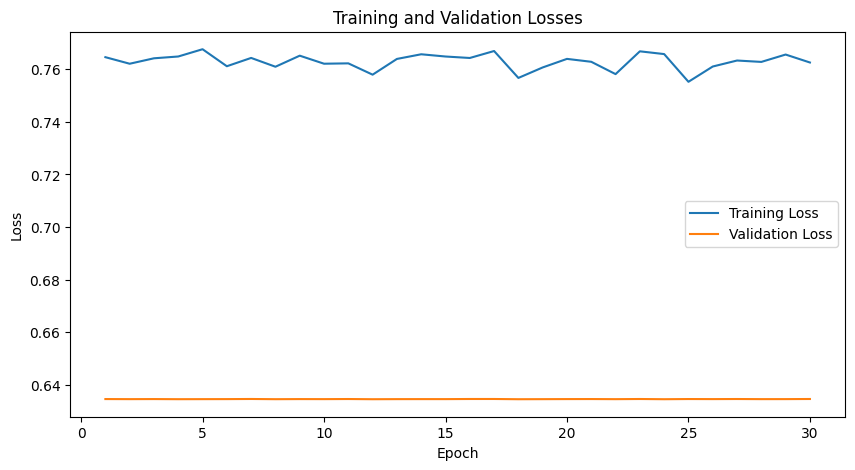

In [3]:
import matplotlib.pyplot as plt
import re


loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/loss_dose_json_simpleModel.txt'

epochs = []
training_losses = []
validation_losses = []

with open(loss_file_path, 'r') as file:
    for line in file:
        match_epoch = re.search(r'Epoch: (\d+)/\d+, Loss: (\d+\.\d+), Val: (\d+\.\d+)', line)
        if match_epoch:
            epochs.append(int(match_epoch.group(1)))
            training_losses.append(float(match_epoch.group(2)))
            validation_losses.append(float(match_epoch.group(3)))


print("Epochs:", epochs)
print("Training Losses:", training_losses)
print("Validation Losses:", validation_losses)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [5]:
from utilities import list_patient_folders, prepare_data

# Specify the directory where the patient folders are located
data_path = '/home/shahpouriz/Data/DBP_newDATA/DBP/nifti/proton'

# Get the list of patient folders
patient_list = list_patient_folders(data_path)


pct_val, rct_val, pos_val = prepare_data(data_path, patient_list)
pct_test, rct_test, pos_test = prepare_data(data_path, patient_list)

val_dict = [{"plan": img[0], "repeat": tar, "pos": pos} for img, tar, pos in zip(pct_val, rct_val, pos_val)]

test_dict = [{"plan": img[0], "repeat": tar, "pos": pos} for img, tar, pos in zip(pct_test, rct_test, pos_test)]



test_files = test_dict[-20:]
val_files = val_dict[-20:]

from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, SpatialPadd, CenterSpatialCropd, ScaleIntensityRanged
from monai.data import CacheDataset, DataLoader, Dataset
from monai.transforms import LoadImaged
from monai.data.image_reader import ITKReader


# Assuming the desired input size for the model is [96, 96, 96]
desired_size = [256, 256, 256]

transforms = Compose([
        LoadImaged(keys=["plan", "repeat"], reader=ITKReader()),
        
        EnsureChannelFirstd(keys=["plan", "repeat"]),
        ScaleIntensityRanged(
            keys=["plan", "repeat"],
            a_min=-1000,
            a_max=1000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Spacingd(keys=["plan", "repeat"], pixdim=(3.0, 3.0, 3.0), mode='trilinear'),
        SpatialPadd(keys=["plan", "repeat"], spatial_size=(128, 128, 128), mode='constant'),  # Ensure minimum size
        CenterSpatialCropd(keys=["plan", "repeat"], roi_size=(128, 128, 128)),  # Ensure uniform size
    ])


test_ds = CacheDataset(data=test_files, transform=transforms, cache_rate=1.0, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

Repeated CT files for P1: ['/home/shahpouriz/Data/DBP_newDATA/DBP/nifti/proton/DBP_OP013/DBP_OP013_P1_repeatedCT8.nii.gz', '/home/shahpouriz/Data/DBP_newDATA/DBP/nifti/proton/DBP_OP013/DBP_OP013_P1_repeatedCT10.nii.gz', '/home/shahpouriz/Data/DBP_newDATA/DBP/nifti/proton/DBP_OP013/DBP_OP013_P1_repeatedCT16.nii.gz', '/home/shahpouriz/Data/DBP_newDATA/DBP/nifti/proton/DBP_OP013/DBP_OP013_P1_repeatedCT6.nii.gz', '/home/shahpouriz/Data/DBP_newDATA/DBP/nifti/proton/DBP_OP013/DBP_OP013_P1_repeatedCT15.nii.gz', '/home/shahpouriz/Data/DBP_newDATA/DBP/nifti/proton/DBP_OP013/DBP_OP013_P1_repeatedCT38.nii.gz', '/home/shahpouriz/Data/DBP_newDATA/DBP/nifti/proton/DBP_OP013/DBP_OP013_P1_repeatedCT20.nii.gz', '/home/shahpouriz/Data/DBP_newDATA/DBP/nifti/proton/DBP_OP013/DBP_OP013_P1_repeatedCT18.nii.gz', '/home/shahpouriz/Data/DBP_newDATA/DBP/nifti/proton/DBP_OP013/DBP_OP013_P1_repeatedCT34.nii.gz', '/home/shahpouriz/Data/DBP_newDATA/DBP/nifti/proton/DBP_OP013/DBP_OP013_P1_repeatedCT5.nii.gz', '/home

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 33.32it/s]


In [7]:
device = torch.device(f"cuda:1" if torch.cuda.is_available() else "cpu")
saved_model_path = '/home/shahpouriz/Data/DBP_Project/LOG/model_weights_dose_4.pt'
model = Dual(width=512, height=512, depth=512)  # Assuming the model architecture is Dual
model.load_state_dict(torch.load(saved_model_path))
model.to(device)  # Make sure to move the model to the appropriate device (CPU or GPU)
mae_loss = torch.nn.L1Loss()
mse_loss = torch.nn.MSELoss()

# Evaluate the model on the test set
model.eval()
test_loss = []
with torch.no_grad():
    for batch_data in test_loader:
        pCT_test, rCT_test = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg_test = batch_data["pos"].clone().detach().requires_grad_(True).to(device)  # If gradients are required for 'reg'

        output_test = model(pCT_test, rCT_test)
        loss_test = mae_loss(output_test, reg_test)

        test_loss.append(loss_test.item())

mean_test_loss = np.mean(test_loss)
print(f'Test Loss: {mean_test_loss:.4f}')


Test Loss: 0.6346


Ground Truth: [-1.12993 -0.59668  1.00013]
metatensor([[  236.9341, -2290.3901,  -122.7172]])
Coordination predicted by model: [  236.93407 -2290.3901   -122.71723]


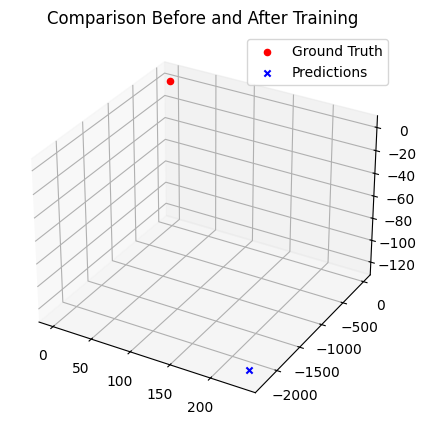

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from monai.transforms import LoadImaged
from monai.data.image_reader import ITKReader

load_image = LoadImaged(keys=["plan", "repeat"], reader=ITKReader())
sample_data = test_files[0]  

sample_data = load_image(sample_data)
pCT = sample_data["plan"].unsqueeze(0).unsqueeze(0).to(device)
rCT = sample_data["repeat"].unsqueeze(0).unsqueeze(0).to(device)
ground_truth = sample_data["pos"]
print("Ground Truth:", ground_truth)

model.eval()
with torch.no_grad():
    prediction = model(pCT, rCT)
prediction = prediction[0].cpu().numpy()
print("Coordination predicted by model:", prediction)

# Plot ground truth and predictions
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ground_truth[0], ground_truth[1], ground_truth[2], c='r', marker='o', label='Ground Truth')
ax.scatter(prediction[0], prediction[1], prediction[2], c='b', marker='x', label='Predictions')

ax.set_title('Comparison Before and After Training')
ax.legend()

plt.show()


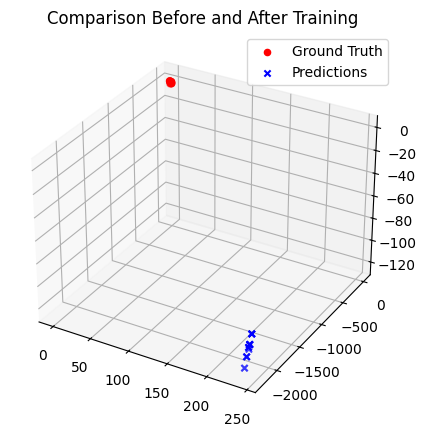

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from monai.transforms import LoadImaged
from monai.data.image_reader import ITKReader

# Function to plot ground truth and predictions
def plot_samples(test_files, model, device):
    all_ground_truth = []
    all_predictions = []

    for sample_data in test_files:
        sample_data = load_image(sample_data)
        pCT = sample_data["plan"].unsqueeze(0).unsqueeze(0).to(device)
        rCT = sample_data["repeat"].unsqueeze(0).unsqueeze(0).to(device)
        ground_truth = sample_data["pos"]
        

        model.eval()
        with torch.no_grad():
            prediction = model(pCT, rCT)
        prediction = prediction[0].cpu().numpy()
        

        all_ground_truth.append(ground_truth)
        all_predictions.append(prediction)

    # Plot all ground truth and predictions in a single 3D plot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for ground truth
    all_ground_truth = np.array(all_ground_truth)
    ax.scatter(all_ground_truth[:, 0], all_ground_truth[:, 1], all_ground_truth[:, 2], c='r', marker='o', label='Ground Truth')

    # Scatter plot for predictions
    all_predictions = np.array(all_predictions)
    ax.scatter(all_predictions[:, 0], all_predictions[:, 1], all_predictions[:, 2], c='b', marker='x', label='Predictions')

    ax.set_title('Comparison Before and After Training')
    ax.legend()

    plt.show()

# Load test data
test_files = test_dict[-20:]

# Plot all ground truth and predictions in a single 3D plot
plot_samples(test_files, model, device)


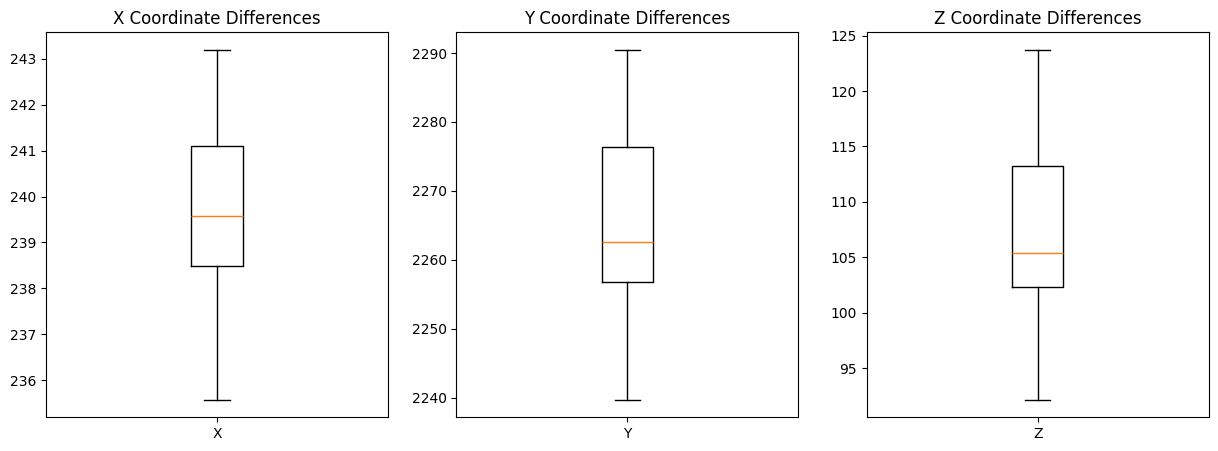

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from monai.transforms import LoadImaged
from monai.data.image_reader import ITKReader

# Lists to store differences for each coordinate
x_diffs, y_diffs, z_diffs = [], [], []

# Iterate through all test samples
for sample_data in test_files:
    load_image = LoadImaged(keys=["plan", "repeat"], reader=ITKReader())
    sample_data = load_image(sample_data)

    pCT = sample_data["plan"].unsqueeze(0).unsqueeze(0).to(device)
    rCT = sample_data["repeat"].unsqueeze(0).unsqueeze(0).to(device)
    ground_truth = sample_data["pos"]
    
    # Get the model prediction
    model.eval()
    with torch.no_grad():
        prediction = model(pCT, rCT)
    prediction = prediction[0].cpu().numpy()

    # Calculate differences
    x_diff = np.abs(ground_truth[0] - prediction[0])
    y_diff = np.abs(ground_truth[1] - prediction[1])
    z_diff = np.abs(ground_truth[2] - prediction[2])

    # Append differences to the lists
    x_diffs.append(x_diff)
    y_diffs.append(y_diff)
    z_diffs.append(z_diff)

# Create box plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].boxplot(x_diffs, labels=['X'])
axes[0].set_title('X Coordinate Differences')

axes[1].boxplot(y_diffs, labels=['Y'])
axes[1].set_title('Y Coordinate Differences')

axes[2].boxplot(z_diffs, labels=['Z'])
axes[2].set_title('Z Coordinate Differences')

plt.show()
